# Semantic Brain Decoding

This notebook is meant to reproduce our work.
Starting from pre-trained brain to features models and nearest neighbors classifier, this notebook will condition a latent diffusion model to generate semantically plausible reconsructions of target images used as stimuli during the fMRI experiment.

In [9]:

import nibabel as nib
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from os.path import join as opj
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')

import tqdm
from torchsummary import summary
from PIL import Image

from sklearn.model_selection import train_test_split
import shutil
from scipy.stats import hypergeom
import seaborn as sns
from termcolor import colored
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nibabel.processing
import pickle
from scipy.io import loadmat
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from god_decoding_utils import *

from sklearn.metrics import classification_report

from torch import autocast
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline

from PIL import Image
import ast

import wandb
from PIL import ImageFilter



/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")
[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/matteo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1. Data Loading

Processed data can be downloaded from https://figshare.com/articles/dataset/Generic_Object_Decoding/7387130 

For copyright reasons, authors didn't make the visual images used in our experiments publicly available. 
You can request us to share the stimulus images at https://forms.gle/ujvA34948Xg49jdn9.

Stimulus images used for higher visual area locazlier experiments in this study are available via https://forms.gle/c6HGatLrt7JtTGQk7.

To run the following cells:

1) put the downloaded fMRI files in the "data/fMRI/GOD" folder 
2) put the downloaded image stimuli in the "data/fMRI/imagenet/images" folder.
 


In [10]:
# Initialize sub and roi variables
# You can change sub to each number in [1-5]
sub = "3"
roi = "ROI_VC"

# Initialize kamitani_data_mat with the path to a file containing data for Subject 3
kamitani_data_mat = f"data/fMRI/GOD/Subject{sub}.h5"

# Initialize imagenet_dir with the path to a directory containing images
imagenet_dir = "data/fMRI/imagenet/images"

# Initialize test_img_csv and train_img_csv with the paths to two CSV files
test_img_csv = 'data/fMRI/GOD/imageID_test.csv'
train_img_csv = 'data/fMRI/GOD/imageID_training.csv'

# Create a data_handler object using the specified arguments
handler = data_handler(h5_file=kamitani_data_mat, test_img_csv=test_img_csv, train_img_csv=train_img_csv)

# Get data using the get_data method of the handler object
Y, Y_test, Y_test_avg = handler.get_data(normalize=1, roi=roi)

# Get labels using the get_labels method of the handler object
labels_train, labels = handler.get_labels()

# Get filenames using the get_filenames method of the handler object
filenames_train, filenames_test = handler.get_filenames()

# Convert filenames_train and filenames_test from arrays to Python lists
filenames_train = [i.item() for i in filenames_train]
filenames_test = [i.item() for i in filenames_test]

# Initialize an empty list called filenames_test_avg
filenames_test_avg = []

# Iterate 50 times
for i in range(50):
    # Append the first element from filenames_test whose label is equal to i to filenames_test_avg
    filenames_test_avg.append(np.array(filenames_test)[labels==i][0])


### Handle WordNet Mapping

ImageNet synsets (image names) are mapped to WordNet.

In [11]:
with open('class_to_wordnet.json',) as f:
    data = f.read()

class2wordnet = ast.literal_eval(data)
wordnet2class= {v["id"] : k for k,v in class2wordnet.items()}

In [12]:
# Initialize img_dir_path with the path to a directory containing training images
img_dir_path = "data/fMRI/imagenet/images/training"

# Initialize image_paths with a list of file paths to the training images
image_paths = [os.path.join(img_dir_path, i) for i in filenames_train]

# Initialize test_image_paths with a list of file paths to the test images
test_image_paths = [os.path.join(imagenet_dir,"test", i) for i in filenames_test_avg]

# Split the data into train and validation sets using the train_test_split function
fmri_train, fmri_val, image_train, image_val = train_test_split(Y, image_paths, test_size=0.1, random_state=42)


### Dataset and Dataloaders

A CustomDataset is implemented in the god_utils file that returns fmri data and the related image

In [13]:
# Initialize BS with the batch size
BS = 64

# Initialize normalize with a transformation that normalizes the data
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Initialize transform with a transformation that resizes and converts images to tensors
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                                            torchvision.transforms.ToTensor(),
                                            normalize])

# Initialize train_dataset with a CustomDataset object using the fmri_train and image_train data and the transform
train_dataset = CustomDataset(fmri_train, image_train, transform)

# Initialize val_dataset with a CustomDataset object using the fmri_val and image_val data and the transform
val_dataset = CustomDataset(fmri_val, image_val, transform)

# Initialize test_dataset with a CustomDataset object using the Y_test_avg and test_image_paths data and the transform
test_dataset = CustomDataset(Y_test_avg, test_image_paths, transform)

# Initialize train_dataloader with a DataLoader object using the train_dataset and the specified batch size
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=False)

# Initialize val_dataloader with a DataLoader object using the val_dataset and the specified batch size
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False)

# Initialize test_dataloader with a DataLoader object using the test_dataset and the specified batch size
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False)


## 2. CNN Model
Here is defined the pretrained model to extract features from image. By default in this code, the last layer before classification is used as the latent space that describe the semantic space representation of the image itself, because it is composed by high level features

In [14]:
# Load a pre-trained ResNet50 model from the torchvision library
model = torchvision.models.resnet50(pretrained=True)

# Get the list of child modules of the model
modules = list(model.children())

# Remove the last element of the list of child modules
modules = modules[:-1]

# Create a new Sequential model using the remaining child modules
model = nn.Sequential(*modules)


### Extract the latent representation for each image and store it
The following cell store in list fmri activity and latent representation for each image in the training, validation and test set

In [15]:
# Initialize empty lists to store the data
x_train = []
z_train = []
y_train = []

x_val = []
z_val = []
y_val = []

x_test = []
z_test = []
y_test = []

# Iterate over the train_dataloader, val_dataloader, and test_dataloader
# x are fMRI preprocessed data, y are the image stimuli

with torch.no_grad():
    for x, y in tqdm.tqdm(train_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_train.append(x)
        z_train.append(z.squeeze())
        y_train.append(y)

    for x, y in tqdm.tqdm(val_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_val.append(x)
        z_val.append(z.squeeze())
        y_val.append(y)
    for x, y in tqdm.tqdm(test_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_test.append(x)
        z_test.append(z.squeeze())
        y_test.append(y)

# Concatenate the lists of data into numpy arrays
x_train = torch.cat(x_train, 0).numpy()
z_train = torch.cat(z_train, 0).numpy()
y_train = torch.cat(y_train, 0).numpy()

x_val = torch.cat(x_val, 0).numpy()
z_val = torch.cat(z_val, 0).numpy()
y_val = torch.cat(y_val, 0).numpy()

x_test = torch.cat(x_test, 0).numpy()
z_test = torch.cat(z_test, 0).numpy()
y_test = torch.cat(y_test, 0).numpy()


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


## 3. Brain to Features Model

In [16]:
ridge = pickle.load(open(f"models/ridge_sub{sub}.sav", 'rb'))

### Make predictions with the Ridge Regression brain to feature model

In [17]:
# Use the ridge model to make predictions on the test data
test_predicted = ridge.predict(x_test)

# Add a small value to the standard deviation to prevent division by zero
epsilon = 1e-10

# Standardize the predicted test latent values using the mean and standard deviation of the training data
std_norm_test_latent = (test_predicted - np.mean(test_predicted, axis=0)) / (epsilon + np.std(test_predicted, axis=0))
# Adjust the standardized predicted test latent values using the mean and standard deviation of the training data
test_predicted_adj = std_norm_test_latent * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Use the ridge model to make predictions on the training and validation data
train_predicted = ridge.predict(x_train)
val_predicted = ridge.predict(x_val)

# Print the root mean squared error between the predicted latent values and the actual latent values for the training, validation, and test data
print("rmse", mean_squared_error(z_train, train_predicted))
print("rmse", mean_squared_error(z_val, val_predicted))
print("rmse", mean_squared_error(z_test, test_predicted_adj))
print("rmse", mean_squared_error(z_test, test_predicted))


rmse 0.031131619920862955
rmse 0.20596414469737157
rmse 0.26675824246443525
rmse 0.16932684836048842


## 4. Evaluation
Load the CNN model, image features and classifier.

Image features and relative labels can be extracted using the original ImageNet dataset but since this is time consuming a subset of 500K image features with labels can be downloaded from https://drive.google.com/drive/folders/1wHN1QZkwjan1jp6wDrezWNcCm8kVqOeJ?usp=share_link  

In [18]:
#transform to restore original image means and stds
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])

#where image features are saved
features_path="data/fMRI/imagenet/features/feature_imagenet_500_resnet50.pt"
labels_path="data/fMRI/imagenet/features/labels_imagenet_500_resnet50.pt"

#load image features
features=torch.load(features_path)
labels=torch.load(labels_path)

In [19]:
# Load labels for classifying the images
with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name = pickle.loads(data_dict)

# Load a pre-trained ResNet50 model and use the last fully-connected layer as the classifier head (should be the head of the CNN used before!)
clf = torchvision.models.resnet50(pretrained=True)
modules = list(clf.children())[-1:]
clf = nn.Sequential(*modules)

# Load the Nearest Neighbors model and fit it to the features of the images
nbrs = NearestNeighbors(n_neighbors=5).fit(features.numpy())

In [20]:
# Use the clf model to classify the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

with torch.no_grad():
    # Classify the latent values predicted by the ridge model on the training data
    clf_brain_train = clf(torch.Tensor(train_predicted))
    # Classify the latent values predicted by the resnet model on the training data
    clf_model_train = clf(torch.Tensor(z_train))
    
    # Classify the latent values predicted by the ridge model on the validation data
    clf_brain_val = clf(torch.Tensor(val_predicted))
    # Classify the latent values predicted by the resnet model on the validation data
    clf_model_val = clf(torch.Tensor(z_val))
    
    # Classify the latent values predicted by the ridge model on the test data
    clf_brain_test = clf(torch.Tensor(test_predicted))
    # Classify the latent values predicted by the resnet model on the test data
    clf_model_test = clf(torch.Tensor(z_test))
    
    # Classify the adjusted latent values predicted by the ridge model on the test data
    clf_brain_test_adj = clf(torch.Tensor(test_predicted_adj))
    # Classify the latent values predicted by the resnet model on the test data (no adjustment needed since they were already standardized)
    clf_model_test_adj = clf(torch.Tensor(z_test))


### Predictions from Nearest Neighbors. They are closer to target but the process is slower!

In [21]:
# Use the nearest neighbors model to find the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

# Find the nearest neighbors of the latent values predicted by the ridge model on the training data
nbrs_brain_train = nbrs.kneighbors(train_predicted)
# Find the nearest neighbors of the latent values predicted by the resnet model on the training data
nbrs_model_train = nbrs.kneighbors(z_train)


In [22]:
# Use the nearest neighbors model to find the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

# Find the nearest neighbors of the latent values predicted by the ridge model on the validation data
nbrs_brain_val = nbrs.kneighbors(val_predicted)
# Find the nearest neighbors of the latent values predicted by the resnet model on the validation data
nbrs_model_val = nbrs.kneighbors(z_val)

# Find the nearest neighbors of the latent values predicted by the ridge model on the test data
nbrs_brain_test = nbrs.kneighbors(test_predicted)
# Find the nearest neighbors of the latent values predicted by the resnet model on the test data
nbrs_model_test = nbrs.kneighbors(z_test)

# Find the nearest neighbors of the adjusted latent values predicted by the ridge model on the test data
nbrs_brain_test_adj = nbrs.kneighbors(test_predicted_adj)
# Use the same nearest neighbors as for the unadjusted latent values for the resnet model on the test data
nbrs_model_test_adj = nbrs_model_test


In [23]:
# Get the labels for the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

# Get the labels for the nearest neighbors of the latent values predicted by the ridge model on the training data
nbrs_brain_train = labels[nbrs_brain_train[1]]
# Get the labels for the nearest neighbors of the latent values predicted by the resnet model on the training data
nbrs_model_train = labels[nbrs_model_train[1]]

# Get the labels for the nearest neighbors of the latent values predicted by the ridge model on the validation data
nbrs_brain_val = labels[nbrs_brain_val[1]]
# Get the labels for the nearest neighbors of the latent values predicted by the resnet model on the validation data
nbrs_model_val = labels[nbrs_model_val[1]]

# Get the labels for the nearest neighbors of the latent values predicted by the ridge model on the test data
nbrs_brain_test = labels[nbrs_brain_test[1]]
# Get the labels for the nearest neighbors of the latent values predicted by the resnet model on the test data
nbrs_model_test = labels[nbrs_model_test[1]]

# Get the labels for the nearest neighbors of the adjusted latent values predicted by the ridge model on the test data
nbrs_brain_test_adj = labels[nbrs_brain_test_adj[1]]
# Use the same nearest neighbors labels as for the unadjusted latent values for the resnet model on the test data
nbrs_model_test_adj = nbrs_model_test


### Evaluation Functions


In [24]:
def evaluate_topk(brain, model, k1=5, k2=5):
    """This function takes as input two sets of predictions (brain and model) 
    and two integers (k1 and k2) representing the number of top predictions 
    to consider for each set. It returns a dictionary of the proportion of 
    predictions for each overlap between the top-k predictions from the brain model and the image model"""

    # Initialize a dictionary to store the accuracy for each overlap of the top-k predictions from the brain and model models
    acc = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    
    # Iterate over the predictions for each sample
    for i in range(len(brain)):
        # Get the unique indices of the top-k predictions from the brain model and the top-k predictions from the model model
        n_un = len(torch.cat((torch.topk(brain[i], 5).indices, torch.topk(model[i], 5).indices)).unique())
        # Calculate the overlap between the top-k predictions from the brain model and the top-k predictions from the model model
        n_overlap = int(k1 + k2) - n_un
        
        # Increment the accuracy for the current overlap
        acc[n_overlap] += 1
        
    # Calculate the proportion of predictions for each overlap
    for k in acc.keys():
        acc[k] /= len(brain)
    return acc


In [29]:
def evaluate_topk_nbrs(brain, model):

    """
    This function compares the labels predicted by two models (brain and model) 
    on a set of samples and counts the number of samples with a certain number 
    of overlapping labels. It does this by iterating over the samples, comparing 
    the labels element-wise, and counting the number of labels that are present in both sets. 
    The counts are stored in a dictionary, where the keys are the number of overlapping 
    labels and the values are the number of samples with that number of overlapping labels.
    The function then normalizes the counts by the number of samples and returns the resulting 
    dictionary.
    """

    # Initialize a dictionary to store the number of samples with a certain number of overlapping labels
    acc = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    # Iterate over the samples
    for i in range(len(brain)):
        # Get the labels for the current sample from the brain and model
        t1 = brain[i]
        t2 = model[i]

        # Repeat the model labels so they can be compared element-wise with the brain labels
        compareview = t2.repeat(t1.shape[0], 1).T

        # Find the labels that are present in both the brain and model
        intersection = t1[(compareview == t1).T.sum(1) == 1]
        
        # Count the number of overlapping labels
        n_overlap = len(intersection)
        
        # Increment the count for the corresponding key in the dictionary
        acc[n_overlap] += 1
        
    # Normalize the counts by the number of samples
    for k in acc.keys():
        acc[k] /= len(brain)
        
    # Return the dictionary
    return acc


In [25]:
def top_5_acc(brain, model, k=5):

    """This function takes as input two sets of predictions (brain and model) 
    and an integer (k) representing the number of top predictions to consider. 
    It returns the proportion of predictions for which the top prediction 
    from the model is among the top-k predictions from the brain model. 
    The brain and model variables contain the predicted class probabilities
     for each sample, and the top_5_acc function compares the top prediction 
     from the model model with the top-k predictions from the brain model to determine if they match.
    """
    # Initialize a variable to store the accuracy
    acc = 0
    
    # Iterate over the predictions for each sample
    for i in range(len(brain)):
        # Check if the top prediction from the model model is among the top-k predictions from the brain model
        if model[i].argmax() in torch.topk(brain[i], k).indices:
            # If it is, increment the accuracy
            acc += 1
    # Calculate and return the proportion of correct top-k predictions
    return acc / len(brain)


In [26]:
def top_5_nbrs_acc(brain, model):

    """This function takes as input two sets of predictions (brain and model). 
    It returns the proportion of predictions for which the label with the highest
     count among the top-5 nearest neighbors of the model model's prediction is 
     among the top-5 predictions from the brain model. 
     The brain variable contains the top-5 predictions 
     from the brain model and the model variable contains the labels of 
     the top-5 nearest neighbors of the model model's prediction. 
     The top_5_nbrs_acc function compares the label with the highest count 
     among the top-5 nearest neighbors of the model model's prediction 
     with the top-5 predictions from the brain model to determine if they match.
    """


    # Initialize a variable to store the accuracy
    acc = 0
    
    # Iterate over the predictions for each sample
    for i in range(len(brain)):
        # Get the unique labels and counts of the top-5 nearest neighbors from the model model
        values, counts = nbrs_model_train[i].unique(return_counts=True)
        # Find the label with the highest count among the top-5 nearest neighbors
        knn = values[counts.argmax()]
        
        # Check if the label with the highest count among the top-5 nearest neighbors is among the top-5 predictions from the brain model
        if knn in brain[i]:
            # If it is, increment the accuracy
            acc += 1
    # Calculate and return the proportion of correct top-5 nearest neighbor predictions
    return acc / len(brain)


### Check if the best prediction from brain model is in the 5 most probable predcitions from image model. 
This measure how close the brain model is able to estimate the features from fMRI activity and follow the CNN model.

In [27]:
acc_clf_train_top=top_5_acc(clf_brain_train,clf_model_train)
acc_clf_val_top=top_5_acc(clf_brain_val,clf_model_val)
acc_clf_test_top=top_5_acc(clf_brain_test_adj,clf_model_test)


acc_nbrs_train_top=top_5_nbrs_acc(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val_top=top_5_nbrs_acc(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test_top=top_5_nbrs_acc(nbrs_brain_test_adj,nbrs_model_test)


print(f"[TOP 1] Resnet Head Classifier, Train acc: {acc_clf_train_top} Val acc: {acc_clf_val_top} Test acc: {acc_clf_test_top}")
print(f"[TOP 1] Neighbors Classifier, Train acc: {acc_nbrs_train_top} Val acc: {acc_nbrs_val_top} Test acc: {acc_nbrs_test_top}")


[TOP 1] Resnet Head Classifier, Train acc: 0.9916666666666667 Val acc: 0.1 Test acc: 0.18
[TOP 1] Neighbors Classifier, Train acc: 0.8611111111111112 Val acc: 0.0 Test acc: 0.0


### Overlap between top-5 from brain model predictions and CNN predictions

In [30]:
acc_clf_train=evaluate_topk(clf_brain_train,clf_model_train)
acc_clf_val=evaluate_topk(clf_brain_val,clf_model_val)
acc_clf_test=evaluate_topk(clf_brain_test_adj,clf_model_test)

acc_nbrs_train=evaluate_topk_nbrs(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val=evaluate_topk_nbrs(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test=evaluate_topk_nbrs(nbrs_brain_test_adj,nbrs_model_test)

print(f"[TOP 5] Resnet Head Classifier, \n Train acc: {acc_clf_train} \n Val acc: {acc_clf_val} \nTest acc: {acc_clf_test} \n")
print(f"[TOP 5] Neighbors Classifier, \n Train acc: {acc_nbrs_train} \n Val acc: {acc_nbrs_val} \n Test acc: {acc_nbrs_test}")


[TOP 5] Resnet Head Classifier, 
 Train acc: {0: 0.0, 1: 0.000925925925925926, 2: 0.024074074074074074, 3: 0.12407407407407407, 4: 0.48055555555555557, 5: 0.37037037037037035} 
 Val acc: {0: 0.7666666666666667, 1: 0.18333333333333332, 2: 0.041666666666666664, 3: 0.008333333333333333, 4: 0.0, 5: 0.0} 
Test acc: {0: 0.74, 1: 0.1, 2: 0.06, 3: 0.08, 4: 0.02, 5: 0.0} 

[TOP 5] Neighbors Classifier, 
 Train acc: {0: 0.5648148148148148, 1: 0.18888888888888888, 2: 0.13518518518518519, 3: 0.07222222222222222, 4: 0.025, 5: 0.013888888888888888} 
 Val acc: {0: 0.9416666666666667, 1: 0.05, 2: 0.008333333333333333, 3: 0.0, 4: 0.0, 5: 0.0} 
 Test acc: {0: 0.96, 1: 0.02, 2: 0.02, 3: 0.0, 4: 0.0, 5: 0.0}


Text(0.5, 0, '# of matching between top5')

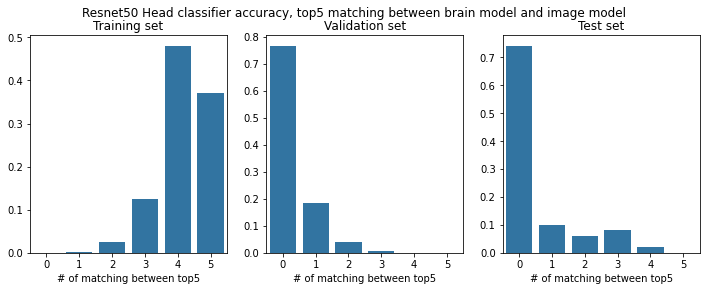

In [31]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Resnet50 Head classifier accuracy, top5 matching between brain model and image model")

sns.barplot(x=list(acc_clf_train.keys()),y=list(acc_clf_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_val.keys()),y=list(acc_clf_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_test.keys()),y=list(acc_clf_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching between top5")



Text(0.5, 0, '# of matching nearest 5')

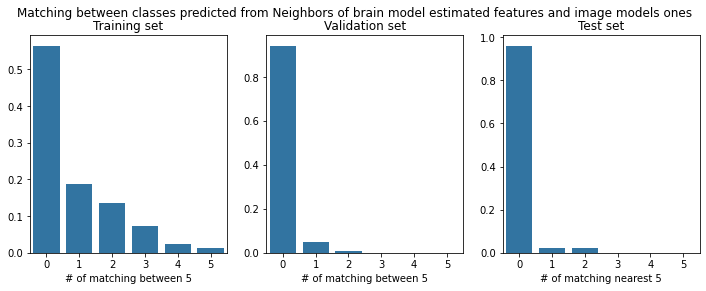

In [32]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Matching between classes predicted from Neighbors of brain model estimated features and image models ones")

sns.barplot(x=list(acc_nbrs_train.keys()),y=list(acc_nbrs_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_val.keys()),y=list(acc_nbrs_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_test.keys()),y=list(acc_nbrs_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching nearest 5")



### WP similarity

for each image, recover the correspondent wordnet ID and synset. Then, compare with the classes predicted by the brain model through the WUP distance https://www.geeksforgeeks.org/nlp-wupalmer-wordnet-similarity/ 

$wup= 2* \frac{depth (lcs)}{depth(syn1)+depth(syn2)}$

In [33]:
def wordnet_to_synset(word_id):
    
    "take a wordnet id in form 2137123-n"
    s=wn.synset_from_pos_and_offset("n",int(word_id.split("-")[0]))
    return s

In [34]:
# Initialize empty lists to store the synsets for the training, validation, and test sets
synset_train = []
synset_val = []
synset_test = []

# Iterate over the training image names
for img_name in image_train:
    # Split the image name by '/' and then by '_' to extract the identifier for the synset
    id = img_name.split("/")[-1].split("_")[0]
    
    # Use the identifier to retrieve the synset from WordNet
    s = wn.synset_from_pos_and_offset("n", int(id[1:]))
    
    # Append the synset to the list for the training set
    synset_train.append(s)
    
# Repeat the process for the validation image names
for img_name in image_val:
    id = img_name.split("/")[-1].split("_")[0]
    s = wn.synset_from_pos_and_offset("n", int(id[1:]))
    synset_val.append(s)
    
# Repeat the process for the test image names
for img_name in test_image_paths:
    id = img_name.split("/")[-1].split("_")[0]
    s = wn.synset_from_pos_and_offset("n", int(id[1:]))
    synset_test.append(s)


In [35]:
# Initialize empty lists to store the synsets for the classifier's output on the training, validation, and test sets
clf_brain_synset_train = []
clf_brain_synset_val = []
clf_brain_synset_test = []

# Iterate over the class labels predicted by the classifier on the training set
for class_label in clf_brain_train.argmax(dim=1):
    # Convert the class label to a WordNet synset using the class2wordnet mapping
    synset = wordnet_to_synset(class2wordnet[class_label.item()]["id"])
    
    # Append the synset to the list for the training set
    clf_brain_synset_train.append(synset)

# Repeat the process for the class labels predicted by the classifier on the validation set
for class_label in clf_brain_val.argmax(dim=1):
    synset = wordnet_to_synset(class2wordnet[class_label.item()]["id"])
    clf_brain_synset_val.append(synset)

# Repeat the process for the class labels predicted by the classifier on the test set
for class_label in clf_brain_test_adj.argmax(dim=1):
    synset = wordnet_to_synset(class2wordnet[class_label.item()]["id"])
    clf_brain_synset_test.append(synset)


In [36]:
#same for classes predicted from nearest neighbors

nbrs_brain_synset_train=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_train]
nbrs_brain_synset_val=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_val]
nbrs_brain_synset_test=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_test_adj]



In [37]:
# Initialize empty lists to store the WUP similarities for the classifier and nearest neighbor models
# on the training, validation, and test sets
train_clf_sim = []
val_clf_sim = []
test_clf_sim = []
train_nbrs_sim = []
val_nbrs_sim = []
test_nbrs_sim = []

# Iterate over pairs of synsets, one from the synset_train list and one from the clf_brain_synset_train list
for syn1, syn2 in zip(synset_train, clf_brain_synset_train):
    # Calculate the WUP similarity between the two synsets
    similarity = syn1.wup_similarity(syn2)
    
    # Append the similarity to the list for the classifier on the training set
    train_clf_sim.append(similarity)

# Repeat the process for the pairs of synsets from the synset_val and clf_brain_synset_val lists
for syn1, syn2 in zip(synset_val, clf_brain_synset_val):
    similarity = syn1.wup_similarity(syn2)
    val_clf_sim.append(similarity)

# Repeat the process for the pairs of synsets from the synset_test and clf_brain_synset_test lists
for syn1, syn2 in zip(synset_test, clf_brain_synset_test):
    similarity = syn1.wup_similarity(syn2)
    test_clf_sim.append(similarity)

# Repeat the process for the pairs of synsets from the synset_train and nbrs_brain_synset_train lists
for syn1, syn2 in zip(synset_train, nbrs_brain_synset_train):
    similarity = syn1.wup_similarity(syn2)
    train_nbrs_sim.append(similarity)

# Repeat the process for the pairs of synsets from the synset_val and nbrs_brain_synset_val lists
for syn1, syn2 in zip(synset_val, nbrs_brain_synset_val):
    similarity = syn1.wup_similarity(syn2)
    val_nbrs_sim.append(similarity)

# Repeat the process for the pairs of synsets from the synset_test and nbrs_brain_synset_test lists
for syn1, syn2 in zip(synset_test, nbrs_brain_synset_test):
    similarity = syn1.wup_similarity(syn2)
    test_nbrs_sim.append(similarity)


In [38]:
print(f"WuPalmer Similarity for argmax of classifier, train: {np.mean(train_clf_sim):.4f} val: {np.mean(val_clf_sim):.4f} test: {np.mean(test_clf_sim):.4f}")
print(f"WuPalmer Similarity for nearest neighbor prediction, train: {np.mean(train_nbrs_sim):.4f} val: {np.mean(val_nbrs_sim):.4f} test: {np.mean(test_nbrs_sim):.4f}")


WuPalmer Similarity for argmax of classifier, train: 0.8135 val: 0.5584 test: 0.5912
WuPalmer Similarity for nearest neighbor prediction, train: 0.7832 val: 0.5444 test: 0.5851


In [39]:
# Define a list of word pairs to compare
couples = [("apple","pear"), ("apple","fruit"), ("apple", "food"), ("apple", "home"), ("apple", "life"), ("apple", "school")]

# Iterate over the word pairs
for n1, n2 in couples:
    # Get the first synset for each word
    syn1 = wn.synsets(n1)[0]
    syn2 = wn.synsets(n2)[0]

    # Calculate the WUP similarity between the two synsets
    sim = syn1.wup_similarity(syn2)
    
    # Print the similarity score
    print(f"wup similarity between {n1} and {n2} is {sim:.3f}")


wup similarity between apple and pear is 0.909
wup similarity between apple and fruit is 0.900
wup similarity between apple and food is 0.462
wup similarity between apple and home is 0.316
wup similarity between apple and life is 0.143
wup similarity between apple and school is 0.125


## 5. Image Reconstructions

In [40]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=True)
pipe = pipe.to("cuda")



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [41]:
def generate_images(labels):

    """This function takes a list of labels as input and generates images 
    that correspond to those labels. It does this by creating a list of prompts, 
    each of which is a string describing an image with a particular label. 
    For example, if the input list is ["apple", "pear"], the prompts will be "An image of an apple" 
    and "An image of a pear".
    The function then uses the pipe() function to generate images from the prompts, and returns the resulting images."""

    # Create a list of prompts using the provided labels
    prompts = [f"An image of a {label}" for label in labels]
    
    # Use the `pipe()` function to generate images from the prompts
    generated = pipe(prompts)
    
    # Return the generated images
    return generated.images


### Random Example
This is a random example in the test set just to look and speed up the process.

nearest ['solar dish, solar collector, solar furnace', 'patio, terrace', 'crane', 'radio telescope, radio reflector', 'lumbermill, sawmill']
clf ['tile roof', 'patio, terrace', 'pier', 'patio, terrace', 'bannister, banister, balustrade, balusters, handrail']
wup distance for closest nbrs: 0.5263157894736842
wup distance for best clf: 0.631578947368421


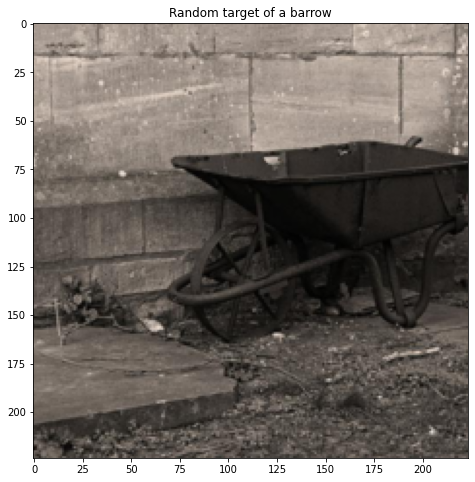

In [52]:
r=np.random.randint(len(test_predicted))
print("nearest",[idx2name[i.item()] for i in torch.topk(clf_brain_test_adj[r],5).indices])

print("clf",[idx2name[i.item()] for i in nbrs_brain_test_adj[r]])
# print([idx2name[i.item()] for i in torch.topk(clf_model_test[r],5).indices])

fig,axs=plt.subplots(1,figsize=(8,8))

axs.imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
axs.set_title(f"Random target of a {synset_test[r].name().split('.n')[0]}")

print(f"wup distance for closest nbrs: {test_nbrs_sim[r]}")

print(f"wup distance for best clf: {test_clf_sim[r]}")

In [43]:
synset_test[r]

Synset('tambourine.n.01')

#### Random reconstructions using prompts from nearest neighbors

In [53]:
# Nearest prompt
nbrs_prompt=[f"An image of a {idx2name[i.item()]}" for i in nbrs_brain_test_adj[r]]
nbrs_image= pipe(nbrs_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

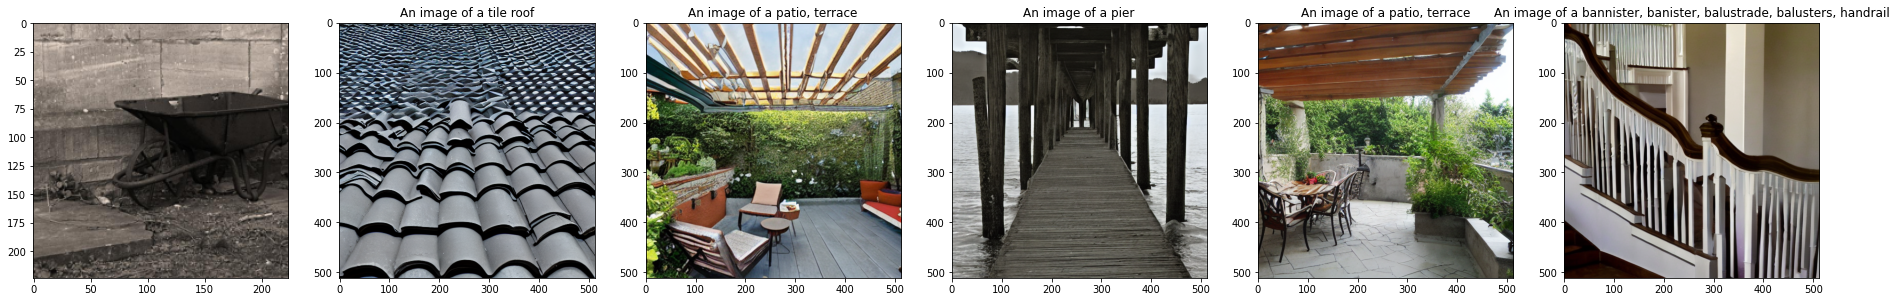

In [54]:
fig,axs=plt.subplots(1,6,figsize=(32,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
for i in range(5):
    axs[i+1].imshow(nbrs_image.images[i])
    axs[i+1].set_title(nbrs_prompt[i])

#### Random reconstructions using prompts from CLF

In [55]:
clf_prompt=[f"An image of a {idx2name[i.item()]}" for i in torch.topk(clf_brain_test_adj[r],5).indices]
clf_image= pipe(clf_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

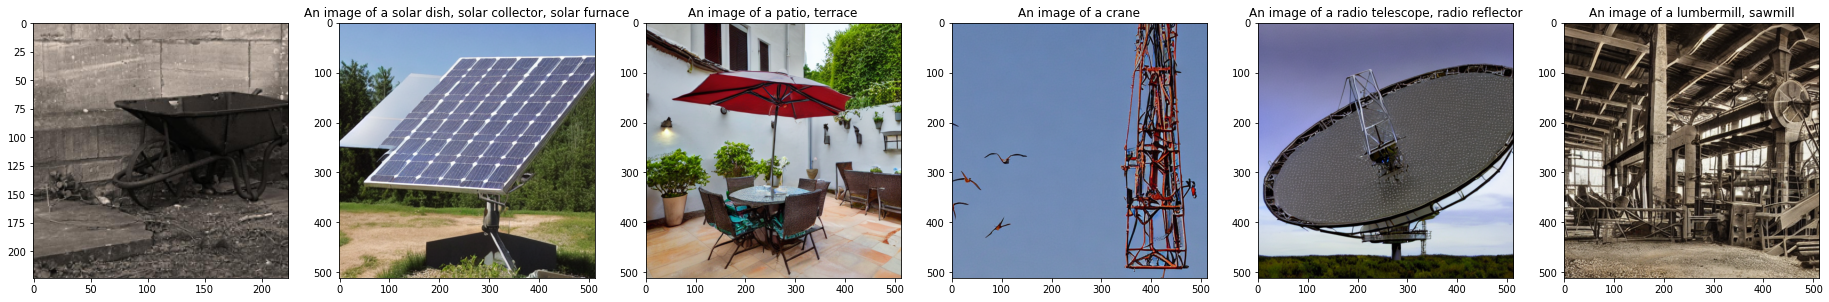

In [56]:
fig,axs=plt.subplots(1,6,figsize=(32,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
for i in range(5):
    axs[i+1].imshow(clf_image.images[i])
    axs[i+1].set_title(clf_prompt[i])


### Reconstruction of the whole test set

In [57]:
# Initialize empty lists to store the generated images for the classifier and nearest neighbor models
clf_generated = []
nbrs_generated = []

# Iterate over the test samples
for r in range(len(y_test)):
    # Get the top 5 class labels for the current sample predicted by the classifier
    clf_labels = [idx2name[i.item()] for i in torch.topk(clf_brain_test[r], 5).indices]
    
    # Generate images for the class labels
    clf_generated.append(generate_images(clf_labels))
    
    # Print progress
    print(f"CLF {r}/{len(y_test)}")

# Repeat the process for the nearest neighbor model
for r in range(len(y_test)):
    # Get the class labels for the current sample predicted by the nearest neighbor model
    nbrs_labels = [idx2name[i.item()] for i in nbrs_brain_test_adj[r]]
    
    # Generate images for the class labels
    nbrs_generated.append(generate_images(nbrs_labels))
    
    # Print progress
    print(f"NBRS {r}/{len(y_test)}")


  0%|          | 0/50 [00:00<?, ?it/s]

CLF 0/50


  0%|          | 0/50 [00:00<?, ?it/s]

CLF 1/50


  0%|          | 0/50 [00:00<?, ?it/s]

CLF 2/50


  0%|          | 0/50 [00:00<?, ?it/s]

CLF 3/50


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 4/50


  0%|          | 0/50 [00:00<?, ?it/s]

CLF 5/50


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 6/50


  0%|          | 0/50 [00:00<?, ?it/s]

### Visualization
clf_generated and nbrs are list of 5 generated candidates for each test image.

So they are 50 elements of 5 images for both the predictions from classifier and nearest neighbors.

Change *offset* in the code below to see 10 images with their reconstructions from nbrs for example

In [ ]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axs =plt.subplots(10,6, figsize=(12,20))

offset=10
for j in range(offset,offset+10):
    axs[j-offset,0].imshow(unnorm(torch.Tensor(y_test[j])).permute(1,2,0))
    [x.set_linewidth(3) for x in axs[j-offset,0].spines.values()]

    for i in range(5):
        axs[j-offset,i+1].imshow(nbrs_generated[j][i])
        
axs[0,0].set_title("shown")
for i in range(5):
    axs[0,i+1].set_title("generated")
